In [ ]:
# following for gl

In [ ]:

drive.mount('/content/drive')

# Model parameters
image_size = 224
input_shape = (image_size, image_size, 3)
epochs = 50
batch_size = 32

# Define the dataset path and categories
dataset_path = '/content/drive/My Drive/od_alone'
categories = ['norm','gl']

# Initialize an empty list to store labels
labels = []

# Iterate through the directories in the dataset path
for category in categories:
    category_path = os.path.join(dataset_path, category)
    # Check if the directory exists and is indeed a directory
    if os.path.isdir(category_path):
        # List all files in the category directory
        file_names = os.listdir(category_path)
        # Iterate through each file in the directory
        for file_name in file_names:
            # Construct the full file path
            file_path = os.path.join(category_path, file_name)
            # Append the filename and category to the labels list
            labels.append((file_path, category))

# Create a DataFrame from the labels list
df = pd.DataFrame(data=labels, columns=['filename', 'category'])

# Encode the 'category' column
encoder = LabelEncoder()
df['category'] = encoder.fit_transform(df['category'])
print(df.head())
df = df.sample(frac=1).reset_index(drop=True)

# Split the DataFrame into train and validation sets
train_df, validate_df = train_test_split(df, test_size=0.2)

# Load images and labels from DataFrame
X_train = np.array([img_to_array(load_img(img_path, target_size=(image_size, image_size))) for img_path in train_df['filename']])
y_train = np.array(train_df['category'])
X_validate = np.array([img_to_array(load_img(img_path, target_size=(image_size, image_size))) for img_path in validate_df['filename']])
y_validate = np.array(validate_df['category'])

# Normalize pixel values to the range [0, 1]
X_train = X_train / 255.0
X_validate = X_validate / 255.0



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                            filename  category
0  /content/drive/My Drive/od_alone/norm/processe...         1
1  /content/drive/My Drive/od_alone/norm/processe...         1
2  /content/drive/My Drive/od_alone/norm/processe...         1
3  /content/drive/My Drive/od_alone/norm/processe...         1
4  /content/drive/My Drive/od_alone/norm/processe...         1


In [ ]:
pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False
for layer in pre_trained_model.layers[15:]:
    layer.trainable = True

last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = GlobalMaxPooling2D()(last_output)

x = BatchNormalization(axis=1)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(categories), activation='softmax')(x)
model = Model(pre_trained_model.input, x)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(lr=3e-4),
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])



Epoch 1/50
7/7 [==============================] - 10s 1s/step - loss: 0.2253 - accuracy: 0.8860 - val_loss: 16.3284 - val_accuracy: 0.4490
Epoch 2/50
7/7 [==============================] - 1s 184ms/step - loss: 0.0093 - accuracy: 0.9948 - val_loss: 30.0982 - val_accuracy: 0.4490
Epoch 3/50
7/7 [==============================] - 1s 183ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 18.6435 - val_accuracy: 0.4490
Epoch 4/50
7/7 [==============================] - 1s 172ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 2.7815 - val_accuracy: 0.6122
Epoch 5/50
7/7 [==============================] - 1s 186ms/step - loss: 0.0042 - accuracy: 0.9948 - val_loss: 1.7030e-08 - val_accuracy: 1.0000
Epoch 6/50
7/7 [==============================] - 1s 177ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.1324e-05 - val_accuracy: 1.0000
Epoch 7/50
7/7 [==============================] - 1s 181ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.0184 - val_accuracy: 0.9796
Epoch 8/50


2/2 [==============================] - 0s 111ms/step
Classification Report:
              precision    recall  f1-score   support

        norm       1.00      1.00      1.00        22
          gl       1.00      1.00      1.00        27

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49



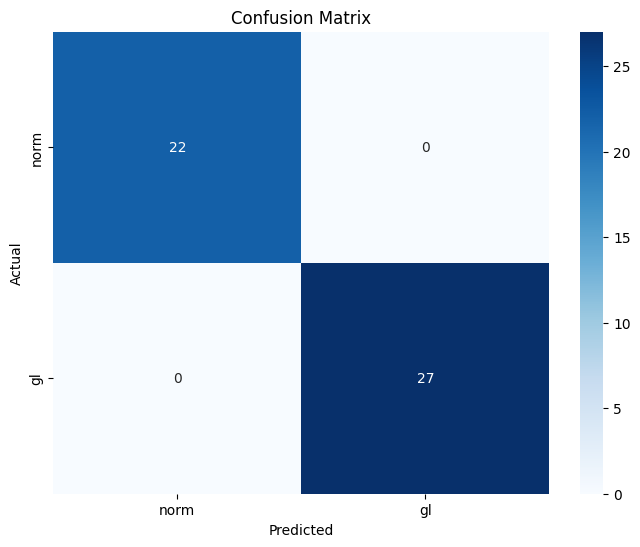

In [ ]:
y_pred = np.argmax(model.predict(X_validate), axis=-1)

# Generate classification report
print("Classification Report:")
print(classification_report(y_validate, y_pred, target_names=categories))

# Generate confusion matrix
cm = confusion_matrix(y_validate, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()